Sentiment Analysis refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. Sentiment analysis is widely applied to voice of the customer materials such as reviews and survey responses, online and social media, and healthcare materials for applications that range from marketing to customer service to clinical medicine.[Source: Wikipedia]

in this part i attempt to perform sentiment analysis using Word2Vec Text Embedding from [**gensim**](https://github.com/RaRe-Technologies/gensim).

# Importing the Required Libraries

load all necessary libraries here

In [1]:
# common library
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import cm
%matplotlib notebook
import pickle
import string
import multiprocessing

# NLP
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, LSTM, Bidirectional
from tensorflow.keras.layers import Input,Flatten,Reshape
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Embedding,concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from gensim.models import Word2Vec, KeyedVectors
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

# function
import sys
sys.path.append('function/')
from ursar import nlp

# Importing the Dataset

import the dataset from pickle file

In [2]:
# load train dataset file here
with open('DATA/clean_text_train', 'rb') as picklefile:
    train = pickle.load(picklefile)

# load test dataset file here
with open('DATA/clean_text_test', 'rb') as picklefile:
    test = pickle.load(picklefile)

In [3]:
# load label train dataset file here
with open('DATA/label_train', 'rb') as picklefile:
    y_train = pickle.load(picklefile)

# load label test dataset file here
with open('DATA/label_test', 'rb') as picklefile:
    y_test = pickle.load(picklefile)

# Generating Word2Vec and storing the Model

Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space. [Source: Wikipedia]

we use Skip-Grams for this part 

Skip-Grams:

In Skip-Gram model, we take a centre word and a window of context words or neighbors within the context window and we try to predict context words for each centre word. The model generates a probability distribution i.e., probability of a word appearing in context given centre word and the task here is to choose the vector representation to maximize the probability.

In [4]:
# tokenize
def tokenize(msg):
    clean = [char for char in msg if char not in string.punctuation]
    clean = ''.join(clean)
    return clean.lower().split()

In [5]:
# find the longest sentence
longest = 0
for review in train:
    if len(tokenize(review)) > longest:
        longest = len(review)
print(longest)

108


## Create Word to Vector

In [6]:
def train_w2v(corpus, size, min_count):
    docs = [tokenize(doc) for doc in corpus]
    model = Word2Vec(docs, sg=1,
                                   size=size,
                                   window=5,
                                   min_count=min_count,
                                   workers=multiprocessing.cpu_count())
    model.train(docs, total_examples=len(docs), epochs=10)
    return model

In [7]:
w2v = train_w2v(train,400,2)

## test our w2v

In [8]:
w2v.wv.most_similar("enak")

[('pizzanya', 0.924150824546814),
 ('beneran', 0.9108680486679077),
 ('soto', 0.9107822775840759),
 ('hemat', 0.9088972806930542),
 ('padan', 0.9034178256988525),
 ('varian', 0.8979251384735107),
 ('segitu', 0.8978403210639954),
 ('geleng', 0.8952893614768982),
 ('sedap', 0.8937811851501465),
 ('hehehe', 0.8919240236282349)]

# save the model

In [9]:
w2v.wv.save_word2vec_format('model/model_w2v_skipgram.bin', binary=True)

In [10]:
word_vectors = KeyedVectors.load_word2vec_format('model/model_w2v_skipgram.bin', binary=True)

# Parameters

In [8]:
vocab_size = 1500
EMBEDDING_DIM=400
max_length = 120
padding_type = 'post'
trunc_type = 'post'

## Tokenizer

use the tokenizer class from the module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key

In [9]:
# create the tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train)

# encode training data set
X_train = tokenizer.texts_to_sequences(train)
X_train = pad_sequences(X_train, padding=padding_type, maxlen=max_length)
word_index = tokenizer.word_index
print(X_train.shape)

(1780, 120)


In [10]:
X_test = tokenizer.texts_to_sequences(test)
X_test = pad_sequences( X_test, padding=padding_type, maxlen=max_length)
print(X_test.shape)

(185, 120)


In [11]:
# save train dataset
with open('model/tokenizer_embed', 'wb') as picklefile:
    pickle.dump(tokenizer,picklefile)

# Embedding

word Embeddings is numerical representation of words to enable our model to learn.

The "embedding" way to read the text is as follows:

* Create a word dictionary by listing all the words in the dataset
* Each time a string is received, the string is converted into an float by giving it a number. This numbering can be determined according to the corelation with other word with close meaning and contain more information.

In [15]:
vocabulary_size=min(len(word_index)+1,vocab_size)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=vocab_size:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

# Text Classification with CNN

Convolutional neural networks (CNN)

CNN uses a multi-layer neural network with a convolutional layer, multiple dense layers of neurons with a sigmoid activation function, and additional layers designed to prevent overfitting. 

the filters will enable us to highlight the intensely positive or intensely negative words. They will enable us to understand the relation between negations and what follows, and things like that. It will capture relevant information about how the words follow each other. It will also learn particular words or n-grams that bear sentiment information. We then feed a fully connected deep neural network with the outputs of these convolutions. It selects the best of these features in order to classify the sentiment of the sentence.

Acrhitecture of Network:

===============================================================================

Embedding -> Conv1D -> Global Max Pooling 1D -> Output

===============================================================================

Total params: 753,857

Trainable params: 753,857

Non-trainable params: 0

In [16]:
cnn_filters=50
kernel_size = 3
filter_sizes = [3,4,5]
num_filters = 128
drop = 0.5

In [17]:
model = Sequential()

model.add(Embedding(vocabulary_size, EMBEDDING_DIM, weights=[embedding_matrix],
                    input_length=max_length,trainable=True))
# model.add(Dropout(0.5))
model.add(Conv1D(num_filters, kernel_size, padding='same', activation='relu', strides=1,kernel_regularizer=regularizers.l2(0.01)))
model.add(GlobalMaxPooling1D())
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer="adam", 
              loss='binary_crossentropy', 
              metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 400)          600000    
_________________________________________________________________
conv1d (Conv1D)              (None, 120, 128)          153728    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 753,857
Trainable params: 753,857
Non-trainable params: 0
_________________________________________________________________
None


# Plot Architecture

<IPython.core.display.Javascript object>


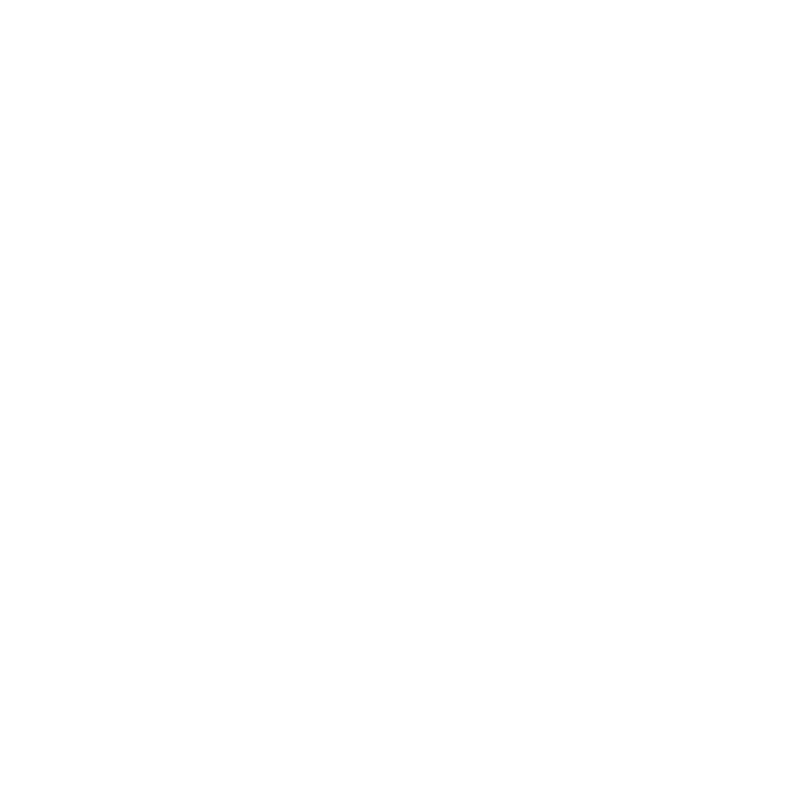

In [18]:
plt.figure(figsize=(8, 8))
plot_model(model, 
           to_file='image/model_CNN.png', 
           show_shapes=True,
           show_layer_names=True)
plt.show()

# Training

In [19]:
history = model.fit(X_train, y_train, 
                    batch_size=128, 
                    epochs=50, 
                    verbose=1,
                    callbacks = [
                        ReduceLROnPlateau(),
                        EarlyStopping(patience=4),
                        ModelCheckpoint(filepath='model/model_CNN.h5', 
                                        save_best_only=True)],
                    validation_split=0.1)

Epoch 1/50
13/13 [==============================] - 1s 59ms/step - loss: 2.1942 - acc: 0.6742 - val_loss: 1.7646 - val_acc: 0.7247 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 0s 36ms/step - loss: 1.4418 - acc: 0.7597 - val_loss: 1.1933 - val_acc: 0.7528 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 1s 52ms/step - loss: 0.9806 - acc: 0.7921 - val_loss: 0.8747 - val_acc: 0.7584 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 0s 36ms/step - loss: 0.7177 - acc: 0.8152 - val_loss: 0.6967 - val_acc: 0.7697 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 0s 36ms/step - loss: 0.5668 - acc: 0.8383 - val_loss: 0.5984 - val_acc: 0.7753 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 0s 38ms/step - loss: 0.4773 - acc: 0.8602 - val_loss: 0.5507 - val_acc: 0.7809 - lr: 0.0010
Epoch 7/50
13/13 [==============================] - 0s 36ms/step - loss: 0.4130 - acc: 0.8695 - val_loss: 0.5242 - val_acc: 0.7809 - lr:

## Evaluation

In [20]:
cnn_model = load_model('model/model_CNN.h5')
loss, accuracy = cnn_model.evaluate(X_train, y_train, verbose=False)
print("\nTraining Accuracy: {:.4f}".format(accuracy))
print("Training loss:  {:.4f}".format(loss))
loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=False)
print("\nTesting Accuracy:  {:.4f}".format(accuracy))
print("Testing loss:  {:.4f}".format(loss))


Training Accuracy: 0.9320
Training loss:  0.2967

Testing Accuracy:  0.8270
Testing loss:  0.5228


# plot history

<IPython.core.display.Javascript object>


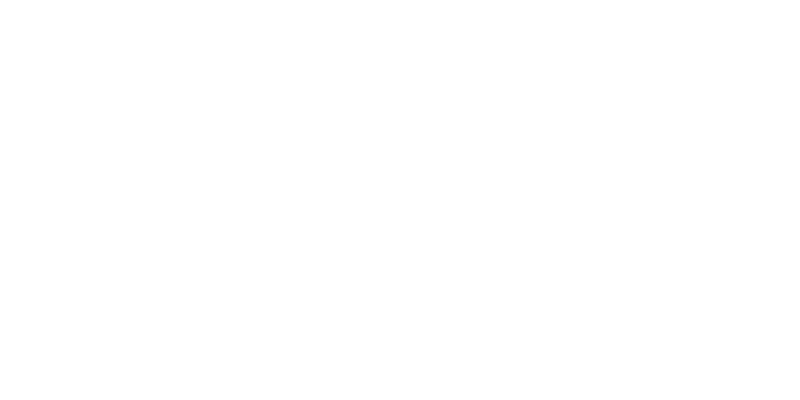

In [21]:
# this function has been save in function/ursar.py so we can call it for every model we create
nlp.plot_history(history)

# Text Classification with CNN-LSTM

### Building the Neural Model

For training a combination of Convolution Neural Network and Bidirectional Long Short Term Memory Network is used (CNN-LSTM).

To prevent overfitting or over training of the network, `EarlyStopping()` is used in `callbacks` thus if the network does not improve or starts overfitting, the training comes to an end.

**Acrhitecture of Network:**

===============================================================================

Embedding -> Conv1D -> Conv1D -> Conv1D -> Max Pooling1D -> Bidirectional LSTM -> Dense -> Dropout -> Dense -> Dropout -> Dense -> Dropout -> Output

===============================================================================

Total params: 1,466,913

Trainable params: 1,466,913

Non-trainable params: 0

In [26]:
inputs = Input(shape=(max_length,))
embedding_layer = Embedding(vocabulary_size,
                        EMBEDDING_DIM,
                        weights=[embedding_matrix],
                        trainable=True)
embedding = embedding_layer(inputs)

conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)

maxpool_0 = MaxPooling1D(max_length - filter_sizes[0] + 1, strides=1)(conv_0)
maxpool_1 = MaxPooling1D(max_length - filter_sizes[1] + 1, strides=1)(conv_1)
maxpool_2 = MaxPooling1D(max_length - filter_sizes[2] + 1, strides=1)(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)

dense1 = Dense(256)(merged_tensor)
dropout = Dropout(drop)(dense1)
lstm_1 = LSTM(128)(dropout)
output = Dense(units=1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(lstm_1)

# this creates a model that includes
model = Model(inputs, output)

model.compile(optimizer="adam", 
              loss='binary_crossentropy', 
              metrics=['acc'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 120, 400)     600000      input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 118, 128)     153728      embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 117, 128)     204928      embedding_3[0][0]                
______________________________________________________________________________________________

<IPython.core.display.Javascript object>


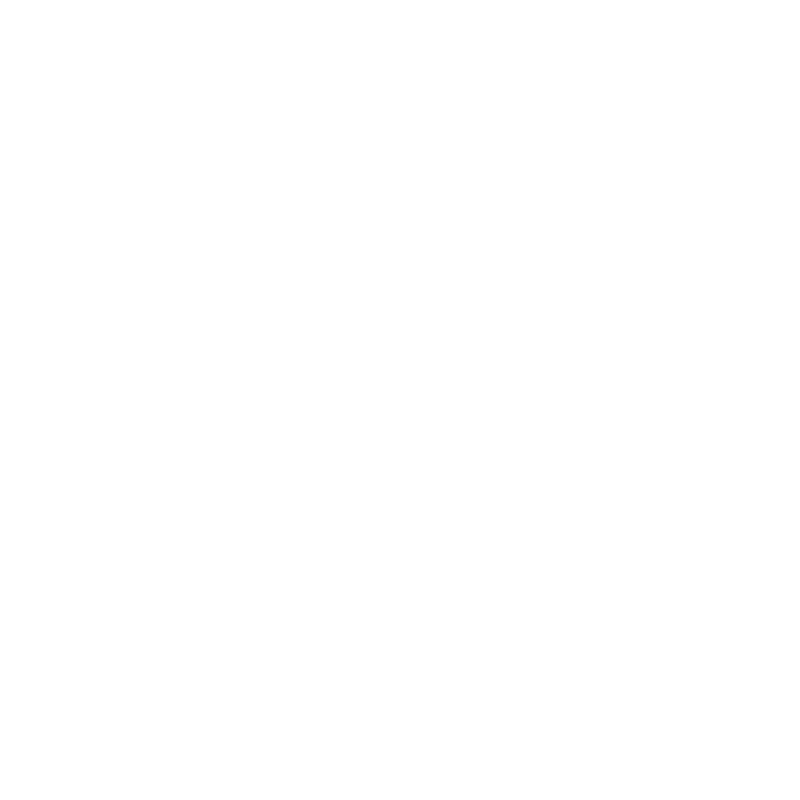

In [34]:
plt.figure(figsize=(8, 8))
plot_model(model, 
           to_file='image/model_CNN_LSTM.png', 
           show_shapes=True,
           show_layer_names=True)
plt.show()

# Training

In [28]:
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=100, 
                    verbose=1,
                    callbacks = [
                        ReduceLROnPlateau(),
                        EarlyStopping(patience=4),
                        ModelCheckpoint(filepath='model/model_CNN_LSTM.h5', 
                                        save_best_only=True)],
                    validation_split=0.1)

Epoch 1/100
51/51 [==============================] - 2s 44ms/step - loss: 2.4642 - acc: 0.7141 - val_loss: 0.9143 - val_acc: 0.6685 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 2s 35ms/step - loss: 0.5777 - acc: 0.8115 - val_loss: 0.5093 - val_acc: 0.8090 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 2s 33ms/step - loss: 0.4314 - acc: 0.8627 - val_loss: 0.4978 - val_acc: 0.7809 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 2s 30ms/step - loss: 0.3255 - acc: 0.9026 - val_loss: 0.6961 - val_acc: 0.7528 - lr: 0.0010
Epoch 5/100
51/51 [==============================] - 1s 29ms/step - loss: 0.2986 - acc: 0.9226 - val_loss: 0.5009 - val_acc: 0.8315 - lr: 0.0010
Epoch 6/100
51/51 [==============================] - 1s 29ms/step - loss: 0.1926 - acc: 0.9613 - val_loss: 0.5158 - val_acc: 0.8146 - lr: 0.0010
Epoch 7/100
51/51 [==============================] - 1s 29ms/step - loss: 0.1557 - acc: 0.9763 - val_loss: 0.6735 - val_acc: 0.825

## Evaluation

In [29]:
cnn_lstm_v2_model = load_model('model/model_CNN_LSTM.h5')
loss, accuracy = cnn_lstm_v2_model.evaluate(X_train, y_train, verbose=False)
print("\nTraining Accuracy: {:.4f}".format(accuracy))
print("Training loss:  {:.4f}".format(loss))
loss, accuracy = cnn_lstm_v2_model.evaluate(X_test, y_test, verbose=False)
print("\nTesting Accuracy:  {:.4f}".format(accuracy))
print("Testing loss:  {:.4f}".format(loss))


Training Accuracy: 0.8949
Training loss:  0.3619

Testing Accuracy:  0.7946
Testing loss:  0.5262


# plot history

<IPython.core.display.Javascript object>


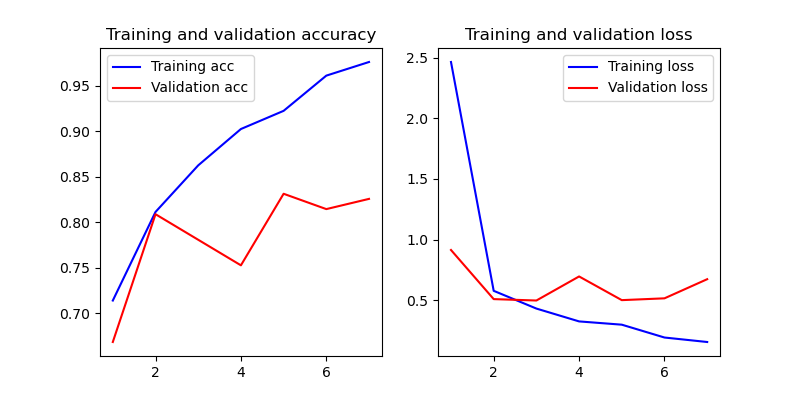

In [36]:
# this function has been save in function/ursar.py so we can call it for every model we create
nlp.plot_history(history)

# Making a Prediction for New Reviews

In [31]:
# classify a review as negative (0) or positive (1)
def predict_sentiment(review, model):
    # apply preprocess_text function to out training dataset
    reviews = []
    print(review)
    reviews.append(nlp.preprocess_text(review))
    # encode
    encoded = nlp.tokenize_embedding(reviews,'post', 120)
    # prediction
    yhat = model.predict(encoded, verbose=0)
    if (yhat[0,0]>=0.5):
        res = "positive review"
    else:
        res = "negative review"
    return (res,yhat[0,0])

In [32]:
# load model
cnn_lstm_model = load_model('model/model_CNN_LSTM.h5')

In [33]:
# test positive text
text = 'Saya telah mencoba pasta dan pizza yang mereka hidangkan, rasanya…. Enak!'
print(predict_sentiment(text, cnn_lstm_model))

Saya telah mencoba pasta dan pizza yang mereka hidangkan, rasanya…. Enak!
('positive review', 0.94835097)
